# Tabular classification notebook

This notebook implements most of the computations for the tabular classification datasets, FICO Challenge and Folktables. It is organized into the following sections (sections in italics are not needed for the core results):
- [**Load and process data**](#Load-and-process-data)
- [*Use scikit-learn models for reference*](#Use-scikit-learn-models-for-reference) *(only for checking that MLP model is decent)*
- [**Train final model**](#Train-final-model)
- [**Further train to obtain gold-standard attribution values**](#Further-train-to-obtain-gold-standard-attribution-values): Not part of this notebook, please see and run the script 'further_train_classification.py'
- [**Load indices of left-out training instances**](#Load-indices-of-left-out-training-instances)
- [**Run gradient-based TDA methods on final model**](#Run-gradient-based-TDA-methods-on-final-model): Grad-Dot, Grad-Cos, etc.
- [**Compare gradient-based methods with further training**](#Compare-gradient-based-methods-with-further-training): Produces the figures in the paper

## Import statements

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

In [2]:
# General data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# FICO dataset pre-processing
from FICO_data import load_and_process_FICO
# folktables
from folktables import ACSDataSource, ACSIncome, generate_categories

In [78]:
# Only needed for comparing with scikit-learn models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [79]:
# Training
from training import train_one_run, train_all_runs

In [3]:
# Gradient-based TDA methods
from torch.func import functional_call, grad, vmap
# DataInf
from collections import defaultdict
from time import time
from tqdm import tqdm
# torch-influence
from torch_influence import BaseObjective, CGInfluenceModule, LiSSAInfluenceModule

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda')

## Load and process data

**Instructions:** 
- Run **either** the [Load and process FICO dataset](#Load-and-process-FICO-dataset) subsection **or** the [Load and process folktables dataset](#Load-and-process-folktables-dataset) subsection
- Then run the common [Save datasets, create `DataLoader`s](#Save-datasets,-create-DataLoaders) subsection

### Load and process FICO dataset

**Instructions:** 
- Download the CSV file from Kaggle: https://www.kaggle.com/datasets/averkiyoliabev/home-equity-line-of-creditheloc
- Place it in a folder such as the one shown in the cell below
- Run the provided pre-processing function `load_and_process_FICO`

In [5]:
dataset = "fico"

In [8]:
data, target = load_and_process_FICO(path=os.path.join("data", "FICO_Challenge", "heloc_dataset_v1 (1).csv"))
target.mean()

/u/dwei/tda/fimo/fimoda/tabular/FICO_data.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.879546809779367' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['MSinceMostRecentDelq']==-8, 'MSinceMostRecentDelq'] = MSinceMostRecentDelqMean


np.float64(0.4796879748758991)

In [9]:
data

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,55.0,144.0,4,84,20,3,0,83,2.0,3,...,43,0,0,0,33.0,68.537973,8.0,1.000000,1.00000,69.0
1,61.0,58.0,15,41,2,4,4,100,84.0,0,...,67,0,0,0,0.0,68.537973,0.0,2.484906,1.09227,0.0
2,67.0,66.0,5,24,9,0,0,100,84.0,7,...,44,0,4,4,53.0,66.000000,4.0,2.000000,1.00000,86.0
3,66.0,169.0,1,73,28,1,1,93,76.0,6,...,57,0,5,4,72.0,83.000000,6.0,4.000000,3.00000,91.0
4,81.0,333.0,27,132,12,0,0,100,84.0,7,...,25,0,1,1,51.0,89.000000,3.0,1.000000,0.00000,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,73.0,131.0,5,57,21,0,0,95,80.0,6,...,19,7,0,0,26.0,68.537973,5.0,2.000000,0.00000,100.0
10455,65.0,147.0,39,68,11,0,0,92,28.0,6,...,42,1,1,1,86.0,53.000000,2.0,2.000000,1.00000,80.0
10456,74.0,129.0,6,64,18,1,1,100,84.0,6,...,33,3,4,4,6.0,68.537973,5.0,2.484906,0.00000,56.0
10457,72.0,234.0,12,113,42,2,2,96,35.0,6,...,20,6,0,0,19.0,68.537973,4.0,1.000000,0.00000,38.0


Split into training and test

In [10]:
test_size = 0.1
seed = 0
features_train, features_test, target_train, target_test = train_test_split(data, target, test_size=test_size, random_state=seed)
num_features = features_train.shape[1]
print(features_train.shape, features_test.shape)
target_train.mean(), target_test.mean()

(8883, 23) (988, 23)


(np.float64(0.4795677136102668), np.float64(0.4807692307692308))

Standardize data

In [11]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
print(features_train.mean(axis=0))
print(features_train.std(axis=0))

[-1.36781276e-16 -1.98372845e-16 -4.07944158e-17  5.21928555e-17
  1.05185601e-16 -1.03985766e-17 -1.91973721e-17 -5.47924996e-16
 -1.35981386e-16  1.02385985e-16  1.91973721e-16 -5.91918974e-17
  1.95973174e-17  1.59978101e-17  2.09971258e-17 -1.15984123e-17
 -3.43952917e-17 -7.87892148e-17 -4.94332332e-16  1.36181359e-16
  3.83947442e-17 -8.63881746e-17  2.14770601e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Convert to `TensorDataset`

In [12]:
dataset_train = TensorDataset(torch.from_numpy(features_train).float(), torch.from_numpy(target_train).long())
dataset_test = TensorDataset(torch.from_numpy(features_test).float(), torch.from_numpy(target_test).long())
dataset_train[0][0][:10], dataset_train[0][1]

(tensor([ 0.6033, -0.0034,  0.0267, -0.1378,  0.8748, -0.4679, -0.3849,  0.3952,
         -1.3695, -1.0566]),
 tensor(1))

### Load and process folktables dataset

In [5]:
dataset = "folktables"

Instantiate `ACSDataSource` object for downloading data

In [6]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')

Download data for Massachusetts, a medium-sized state with not too many samples

In [7]:
data = data_source.get_data(states=["MA"], download=True)
data.shape

(70131, 286)

Dummy-code categorical features using categories downloaded from US Census PUMS

In [8]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)

for k, v in categories.items():
    print(k, len(v))

COW 10
SCHL 25
MAR 6
OCCP 531
POBP 225
RELP 19
SEX 3
RAC1P 10


In [70]:
features, target, group = ACSIncome.df_to_pandas(data, categories=categories, dummies=True)
features.shape

(40114, 791)

The resulting `features` DataFrame has `object` dtypes. Convert to float and identify the numerical features:

In [71]:
features = features.astype(float)
features.head()

,AGEP,WKHP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,COW_Working without pay in family business or farm,...,SEX_Male,RAC1P_Alaska Native alone,RAC1P_American Indian alone,"RAC1P_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",RAC1P_Asian alone,RAC1P_Black or African American alone,RAC1P_Native Hawaiian and Other Pacific Islander alone,RAC1P_Some Other Race alone,RAC1P_Two or More Races,RAC1P_White alone
0,18.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,22.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,18.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,20.0,40.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [72]:
features_num = ["AGEP", "WKHP"]
features[features_num].describe()

,AGEP,WKHP
count,40114.000000,40114.000000
mean,43.196914,37.450865
std,15.833747,13.509709
min,17.000000,1.000000
25%,29.000000,30.000000
50%,43.000000,40.000000
75%,56.000000,45.000000
max,95.000000,99.000000


Convert `target` to integers

In [73]:
target = target.squeeze().astype(int)
target.mean()

np.float64(0.4684399461534626)

Split into training and test

In [74]:
test_size = 0.25
seed = 0
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=test_size, random_state=seed)
num_features = features_train.shape[1]
print(features_train.shape, features_test.shape)
target_train.mean(), target_test.mean()

(30085, 791) (10029, 791)


(np.float64(0.4654478976234004), np.float64(0.47741549506431347))

Standardize numerical features only

In [14]:
scaler = StandardScaler()
scaler.fit(features_train[features_num])
features_train[features_num] = scaler.transform(features_train[features_num])
features_test[features_num] = scaler.transform(features_test[features_num])
print(features_train[features_num].mean(axis=0))
print(features_train[features_num].std(axis=0))

AGEP    1.554054e-16
WKHP   -3.542676e-17
dtype: float64
AGEP    1.000017
WKHP    1.000017
dtype: float64


Convert to `TensorDataset`

In [15]:
dataset_train = TensorDataset(torch.from_numpy(features_train.values).float(), torch.from_numpy(target_train.values).long())
dataset_test = TensorDataset(torch.from_numpy(features_test.values).float(), torch.from_numpy(target_test.values).long())

### Save datasets, create `DataLoader`s

Save processed datasets

In [92]:
os.makedirs(os.path.join("results", dataset), exist_ok=True)
torch.save(dataset_train, os.path.join("results", dataset, "dataset_train.pt"))
torch.save(dataset_test, os.path.join("results", dataset, "dataset_test.pt"))

Load processed datasets

In [16]:
dataset_train = torch.load(os.path.join("results", dataset, "dataset_train.pt"), weights_only=False)
dataset_test = torch.load(os.path.join("results", dataset, "dataset_test.pt"), weights_only=False)
num_features = dataset_train.tensors[0].shape[1]
num_features

791

Create `DataLoader`s

In [17]:
batch_size = 128    # same as in Bae et al., NeurIPS 2022

#dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
#dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=SequentialSampler(dataset_test))

[[back to top]](#Tabular-classification-notebook)

## Use scikit-learn models for reference

To ensure that MLP model is decent

In [95]:
clf = GradientBoostingClassifier(n_estimators=500)

Fit on training data

In [96]:
clf.fit(features_train, target_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Evaluate test accuracy

In [97]:
pred = clf.predict(features_test)
accuracy_score(target_test, pred)

0.8215175989630072

[[back to top]](#Tabular-classification-notebook)

## Train final model

### Create model

In [18]:
hidden_dim = 128    # same as in Bae et al., NeurIPS 2022

In [19]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )
    def forward(self, x):
        return self.linear_relu_stack(x)


Set random seed before initializing model

In [20]:
seed = 0
torch.manual_seed(seed)
model = MLP().to(device)

Save initial model

In [101]:
model_path = os.path.join("results", dataset, "model_initial.pth")
torch.save(model.state_dict(), model_path)

In [102]:
model = MLP().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Train model

Set remaining training parameters

In [103]:
if dataset == "fico":
    learning_rate = 1e-3    # tuned over [1e-5, 1e-4, 1e-3, 1e-2] to minimize test loss
elif dataset == "folktables":
    learning_rate = 1e-2    # tuned over [1e-5, 1e-4, 1e-3, 1e-2] to minimize test loss

In [31]:
loss_fn = nn.CrossEntropyLoss()
loss_fn_per_sample = nn.CrossEntropyLoss(reduction="none")
optimizer_class = torch.optim.SGD
# optimizer_class = torch.optim.Adam

In [105]:
if dataset == "fico":
    num_epochs = 1000
elif dataset == "folktables":
    num_epochs = 100

Train starting from saved initial model and with specified random seed

In [106]:
seed = 0

In [107]:
test_loss_per_sample, model, params_dist = train_one_run(dataset_train, seed, batch_size, None, MLP, model_path, 
                                                         loss_fn, optimizer_class, learning_rate, num_epochs, dataloader_test, loss_fn_per_sample)

Final average training loss per sample: 0.35574112876744596


Check test loss over last several epochs

In [108]:
test_loss_per_sample[-100:].mean(axis=1)

tensor([0.6847, 0.6680, 0.6268, 0.5570, 0.5012, 0.4742, 0.4599, 0.4507, 0.4442,
        0.4399, 0.4338, 0.4299, 0.4276, 0.4226, 0.4187, 0.4161, 0.4125, 0.4131,
        0.4077, 0.4052, 0.4025, 0.4022, 0.3995, 0.3977, 0.3963, 0.4030, 0.3938,
        0.4002, 0.3913, 0.3913, 0.3899, 0.3897, 0.3892, 0.3964, 0.3877, 0.3907,
        0.3903, 0.3855, 0.3897, 0.3848, 0.3832, 0.3966, 0.3950, 0.3828, 0.3861,
        0.3833, 0.3823, 0.4405, 0.3898, 0.3971, 0.3802, 0.3813, 0.3826, 0.3799,
        0.3824, 0.3813, 0.3784, 0.3804, 0.3794, 0.4145, 0.3775, 0.3864, 0.3910,
        0.3761, 0.3820, 0.3788, 0.4706, 0.3766, 0.3959, 0.3892, 0.3882, 0.3816,
        0.3758, 0.3746, 0.3769, 0.3799, 0.3819, 0.3757, 0.4016, 0.3897, 0.3787,
        0.3906, 0.4042, 0.3936, 0.3776, 0.4056, 0.3881, 0.4978, 0.3988, 0.3885,
        0.4118, 0.3765, 0.4387, 0.3758, 0.3940, 0.3745, 0.3841, 0.3900, 0.3872,
        0.3987], device='cuda:0')

Check test accuracy

In [24]:
pred = model(dataset_test.tensors[0].to(device))
(pred.argmax(dim=1) == dataset_test.tensors[1].to(device)).float().mean()

tensor(0.8185, device='cuda:0')

### Save trained model

In [22]:
model_path = os.path.join("results", dataset, "model_final.pth")
torch.save(model.state_dict(), model_path)

In [23]:
model = MLP().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

[[back to top]](#Tabular-classification-notebook)

## Further train to obtain gold-standard attribution values

Please see and run the script 'further_train_classification.py'.

[[back to top]](#Tabular-classification-notebook)

## Load indices of left-out training instances

These will be used in the next section for the folktables dataset. Since folktables is a larger dataset, we will restrict gradient computation to left-out training instances only.

In [25]:
ind_loo = torch.load(os.path.join("results", dataset, "ind_loo.pt"))
ind_loo

tensor([    0,   359,   414,   430,   493,   558,   605,   624,   685,   958,
         1002,  1209,  1303,  1409,  1604,  1812,  2320,  2413,  2461,  2643,
         2701,  3016,  3320,  3617,  3718,  4218,  4398,  4819,  5059,  5314,
         5325,  5419,  5423,  5493,  6024,  6600,  6625,  6703,  7226,  7236,
         7827,  7880,  7966,  8005,  8082,  8431,  8744,  8789,  9033,  9075,
         9292,  9535,  9636,  9743, 10145, 10238, 10602, 10839, 11439, 11516,
        12040, 12120, 12641, 12780, 12899, 13243, 13660, 13729, 13845, 14396,
        14408, 14447, 14643, 15048, 15648, 15663, 16074, 16250, 16850, 17450,
        18050, 18650, 19250, 19850, 20450, 21050, 21650, 22250, 22850, 23450,
        24050, 24650, 25250, 25850, 26450, 27050, 27650, 28250, 28850, 29450])

[[back to top]](#Tabular-classification-notebook)

## Run gradient-based TDA methods on final model

### Compute per-sample gradients of final model (for Grad-Dot, Grad-Cos, DataInf)

This section uses functions from `torch.func` to vectorize the gradient computation (but it is not clear that `torch.func` is significantly faster than a plain `torch` implementation).

Extract model parameters before calling it as a stateless function

In [26]:
params_detached = {k: v.detach() for k, v in model.named_parameters()}

Per-sample loss function for computing gradients

In [27]:
def compute_loss(params, features, target):
    batch = features.unsqueeze(0)
    targets = target.unsqueeze(0)
    
    prediction = functional_call(model, params, (batch,))
    loss = loss_fn(prediction, targets)
    return loss

Transform into function that computes per-sample gradient, then vectorize using `vmap`

In [28]:
compute_grad_vmap = vmap(grad(compute_loss), in_dims=(None, 0, 0))

Compute training and test gradients (for Folktables, restrict the latter to subset of size `num_test_eval`)

In [29]:
num_test_eval = 100

In [32]:
if dataset == "fico":
    grads_train = compute_grad_vmap(params_detached, dataset_train.tensors[0].to(device), dataset_train.tensors[1].to(device))
    grads_test = compute_grad_vmap(params_detached, dataset_test.tensors[0].to(device), dataset_test.tensors[1].to(device))
elif dataset == "folktables":
    grads_train = compute_grad_vmap(params_detached, dataset_train[ind_loo][0].to(device), dataset_train[ind_loo][1].to(device))
    # grads_train = compute_grad_vmap(params_detached, dataset_train.tensors[0].to(device), dataset_train.tensors[1].to(device))
    grads_test = compute_grad_vmap(params_detached, dataset_test[:num_test_eval][0].to(device), dataset_test[:num_test_eval][1].to(device))

for k, v in grads_train.items():
    print(k, v.shape)

linear_relu_stack.0.weight torch.Size([100, 128, 791])
linear_relu_stack.0.bias torch.Size([100, 128])
linear_relu_stack.2.weight torch.Size([100, 128, 128])
linear_relu_stack.2.bias torch.Size([100, 128])
linear_relu_stack.4.weight torch.Size([100, 2, 128])
linear_relu_stack.4.bias torch.Size([100, 2])


Check against plain PyTorch implementation from https://pytorch.org/functorch/stable/notebooks/per_sample_grads.html

In [33]:
def compute_grad(sample, target):
    
    sample = sample.unsqueeze(0)  # prepend batch dimension for processing
    target = target.unsqueeze(0)

    prediction = model(sample)
    loss = loss_fn(prediction, target)

    return torch.autograd.grad(loss, list(model.parameters()))

def compute_sample_grads(data, targets):
    """ manually process each sample with per sample gradient """
    sample_grads = [compute_grad(data[i], targets[i]) for i in range(len(targets))]
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]
    return sample_grads


In [37]:
if dataset == "fico":
    grads_train2 = compute_sample_grads(dataset_train.tensors[0].to(device), dataset_train.tensors[1].to(device))
elif dataset == "folktables":
    grads_train2 = compute_sample_grads(dataset_train[ind_loo][0].to(device), dataset_train[ind_loo][1].to(device))

In [38]:
for grads_layer, grads_layer2 in zip(grads_train.values(), grads_train2):
    print(torch.allclose(grads_layer, grads_layer2, atol=1e-5))

True
True
True
True
True
True


Compute damping strength recommended by Grosse et al. (2023) based on training gradient 2-norms

In [36]:
sum_of_squares = 0
num_elems = 0
for v in grads_train.values():
    sum_of_squares += (v ** 2).sum()
    num_elems += v.numel()

lamb = sum_of_squares / num_elems
lamb

tensor(0.0010, device='cuda:0')

### Compute gradient similarity (Grad-Dot, Grad-Cos)

In [39]:
if dataset == "fico":
    grad_dot = torch.zeros((len(dataset_test), len(dataset_train)), device=device)
    grads_train_norm = torch.zeros(len(dataset_train), device=device)
    grads_test_norm = torch.zeros(len(dataset_test), device=device)
elif dataset == "folktables":
    grad_dot = torch.zeros((num_test_eval, len(ind_loo)), device=device)
    grads_train_norm = torch.zeros(len(ind_loo), device=device)
    grads_test_norm = torch.zeros(num_test_eval, device=device)
# Iterate over model layers
for k, v in grads_train.items():
    # Inner product over all dimensions corresponding to parameters
    num_dims = v.dim()
    grad_dot += torch.tensordot(grads_test[k], grads_train[k], dims=(list(range(1, num_dims)),) * 2)
    grads_train_norm += (grads_train[k] ** 2).sum(dim=list(range(1, num_dims)))
    grads_test_norm += (grads_test[k] ** 2).sum(dim=list(range(1, num_dims)))
grads_train_norm = torch.sqrt(grads_train_norm)
grads_test_norm = torch.sqrt(grads_test_norm)

grad_dot

tensor([[ 2.8149e+00,  3.0671e-01, -4.8643e+01,  ..., -1.1433e-02,
          4.5028e+00,  7.9038e+00],
        [ 1.0614e+01,  5.6929e-01, -7.3572e+01,  ..., -4.0087e-02,
          1.7437e+01,  1.3731e+01],
        [-4.0513e+00, -6.4546e-02,  1.4229e+01,  ...,  2.1046e-02,
         -5.3579e+00, -1.5846e+00],
        ...,
        [-6.0197e-02, -4.4677e-03,  9.7884e-01,  ...,  1.2945e-03,
         -1.6896e-01, -8.6956e-02],
        [ 1.5924e+00,  1.0766e-01, -9.1743e+00,  ..., -4.1468e-03,
          3.0006e+00,  1.8079e+00],
        [-1.4789e+01, -1.9796e-01, -1.0813e+01,  ...,  2.5584e-02,
         -9.6054e+00, -4.2423e+00]], device='cuda:0')

Normalized inner products ("Grad-Cos")

In [40]:
grad_cos = grad_dot / grads_train_norm / grads_test_norm.unsqueeze(1)
grad_cos

tensor([[ 0.2955,  0.4618, -0.4880,  ..., -0.1272,  0.5016,  0.5879],
        [ 0.3489,  0.2684, -0.2312,  ..., -0.1397,  0.6084,  0.3198],
        [-0.3814, -0.0872,  0.1280,  ...,  0.2100, -0.5354, -0.1057],
        ...,
        [-0.1862, -0.1982,  0.2894,  ...,  0.4244, -0.5547, -0.1906],
        [ 0.3951,  0.3831, -0.2175,  ..., -0.1090,  0.7901,  0.3178],
        [-0.5468, -0.1050, -0.0382,  ...,  0.1003, -0.3769, -0.1111]],
       device='cuda:0')

In [41]:
grad_cos.min(), grad_cos.max()

(tensor(-0.8638, device='cuda:0'), tensor(0.8980, device='cuda:0'))

In [102]:
torch.save(grad_dot, os.path.join("results", dataset, "grad_dot.pt"))

In [103]:
torch.save(grad_cos, os.path.join("results", dataset, "grad_cos.pt"))

### DataInf

Restrict computation of DataInf values to subset of test set of size `num_test_eval`

In [42]:
num_test_eval = 100

`IFEngineGeneration` class from https://github.com/ykwon0407/DataInf/blob/main/src/influence.py

In [43]:
class IFEngineGeneration(object):
    '''
    This class computes the influence function for every validation data point
    '''
    def __init__(self):
        self.time_dict = defaultdict(list)
        self.hvp_dict = defaultdict(list)
        self.IF_dict = defaultdict(list)

    def preprocess_gradients(self, tr_grad_dict, val_grad_dict):
        self.tr_grad_dict = tr_grad_dict
        self.val_grad_dict = val_grad_dict

        self.n_train = len(self.tr_grad_dict.keys())
        self.n_val = len(self.val_grad_dict.keys())

    def compute_hvp_proposed(self, lambda_const_param=10):
        start_time = time()
        hvp_proposed_dict=defaultdict(dict)
        for val_id in tqdm(self.val_grad_dict.keys()):
            for weight_name in self.val_grad_dict[val_id]:
                # lambda_const computation
                S=torch.zeros(len(self.tr_grad_dict.keys()))
                for tr_id in self.tr_grad_dict:
                    tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                    S[tr_id]=torch.mean(tmp_grad**2)
                lambda_const = torch.mean(S) / lambda_const_param # layer-wise lambda
                if val_id == 0:
                    print(f"lambda for layer {weight_name} = {lambda_const}")

                # hvp computation
                hvp=torch.zeros(self.val_grad_dict[val_id][weight_name].shape, device=device)
                for tr_id in self.tr_grad_dict:
                    tmp_grad = self.tr_grad_dict[tr_id][weight_name]
                    C_tmp = torch.sum(self.val_grad_dict[val_id][weight_name] * tmp_grad) / (lambda_const + torch.sum(tmp_grad**2))
                    hvp += (self.val_grad_dict[val_id][weight_name] - C_tmp*tmp_grad) / (self.n_train*lambda_const)
                hvp_proposed_dict[val_id][weight_name] = hvp
        self.hvp_dict['proposed'] = hvp_proposed_dict
        self.time_dict['proposed'] = time()-start_time

    def compute_IF(self):
        for method_name in self.hvp_dict:
            print("Computing IF for method: ", method_name)
            if_tmp_dict = defaultdict(dict)
            for tr_id in self.tr_grad_dict:
                for val_id in self.val_grad_dict:
                    if_tmp_value = 0
                    for weight_name in self.val_grad_dict[0]:
                        if_tmp_value += torch.sum(self.hvp_dict[method_name][val_id][weight_name]*self.tr_grad_dict[tr_id][weight_name])
                    if_tmp_dict[tr_id][val_id]=-if_tmp_value

            self.IF_dict[method_name] = pd.DataFrame(if_tmp_dict, dtype=float)   


Convert training and test gradients to DataInf's dictionary format

In [44]:
grads_train_dict = {}
for i in range(len(ind_loo if dataset == "folktables" else dataset_train)):
    grads_train_dict[i] = {}
    for k in grads_train:
        grads_train_dict[i][k] = grads_train[k][i]

grads_test_dict = {}
for i in range(num_test_eval):
    grads_test_dict[i] = {}
    for k in grads_test:
        grads_test_dict[i][k] = grads_test[k][i]

In [45]:
for k, v in grads_train_dict[0].items():
    print(k, v.shape)

linear_relu_stack.0.weight torch.Size([128, 791])
linear_relu_stack.0.bias torch.Size([128])
linear_relu_stack.2.weight torch.Size([128, 128])
linear_relu_stack.2.bias torch.Size([128])
linear_relu_stack.4.weight torch.Size([2, 128])
linear_relu_stack.4.bias torch.Size([2])


Instantiate `IFEngineGeneration` object

In [46]:
IFengine = IFEngineGeneration()
IFengine.preprocess_gradients(grads_train_dict, grads_test_dict)

Compute DataInf influence values for multiple damping values

In [ ]:
lambda_const_params = [10, 1, 0.1, 0.01]
num_lambdas = len(lambda_const_params)
datainf = torch.zeros((num_test_eval, len(ind_loo if dataset == "folktables" else dataset_train), num_lambdas), device=device)

for l, lambda_const_param in enumerate(lambda_const_params):
    print(f"lambda_const_param = {lambda_const_param}")
    # Inverse-Hessian-vector product
    IFengine.compute_hvp_proposed(lambda_const_param=lambda_const_param)
    # Inner product between IHVP and training gradients 
    IFengine.compute_IF()
    # Convert and save influence values
    datainf[:, :, l] = torch.from_numpy(IFengine.IF_dict["proposed"].values).float().to(device)
    torch.save(datainf, os.path.join("results", dataset, "datainf.pt"))


### torch-influence methods (CG, LiSSA, LiSSA-H)

Class that defines training and test losses

In [48]:
class CrossEntropyObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.cross_entropy(outputs, batch[1])  # mean reduction required

    def train_regularization(self, params):
        return torch.tensor(0.)

    # training loss by default taken to be 
    # train_loss_on_outputs + train_regularization

    def test_loss(self, model, params, batch):
        return F.cross_entropy(model(batch[0]), batch[1])  # no regularization in test loss

Instantiate influence modules

In [49]:
# Common parameters
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=SequentialSampler(dataset_train))
damp = 0.001
gnh = True
# gnh = False
# LiSSA parameters
repeat = 1
depth = 5000
# smallest in range [10, 20, 50, 100, 150, 200, 250, 300 400 500] for which algorithm converges
if dataset == "fico":
    scale = 10
elif dataset == "folktables" and gnh:
    scale = 20
elif dataset == "folktables" and not gnh:
    scale = 200

In [50]:
CG_module = CGInfluenceModule(model=model, objective=CrossEntropyObjective(), train_loader=dataloader_train, test_loader=dataloader_test, 
                                device=device, damp=damp, gnh=gnh)

In [51]:
LiSSA_module = LiSSAInfluenceModule(model=model, objective=CrossEntropyObjective(), train_loader=dataloader_train, test_loader=dataloader_test, 
                                   device=device, damp=damp, gnh=gnh, repeat=repeat, depth=depth, scale=scale)

Try different damping values (specifically multiples of the recommended value previously computed from gradient 2-norms)

In [52]:
lambda_scale = [0.1, 1, 10, 100]
num_lambdas = len(lambda_scale)
torch.tensor(lambda_scale) * lamb.item()

tensor([0.0001, 0.0010, 0.0104, 0.1039])

Compute influence scores using CG (**NOTE:** CG may be particularly slow)

In [ ]:
if dataset == "fico":
   cg = torch.zeros((num_test_eval, len(dataset_train), num_lambdas), device=device)
elif dataset == "folktables":
   cg = torch.zeros((num_test_eval, len(ind_loo), num_lambdas), device=device)
for l in range(num_lambdas):
    # Set damping parameter to be multiple of recommended value previously computed
    CG_module.damp = lambda_scale[l] * lamb
    print(f"damp = {CG_module.damp}")
    for i in tqdm(range(num_test_eval)):
        if dataset == "fico":
            cg[i, :, l] = CG_module.influences(range(len(dataset_train)), [i])
        elif dataset == "folktables":
            cg[i, :, l] = CG_module.influences(ind_loo, [i])
        torch.save(cg, os.path.join("results", dataset, "cg.pt"))

**NOTE:** It seems that if `infl_module.influences()` throws an error, then `model.parameters()` becomes empty and the model has to be reloaded

Check that LiSSA converges

In [53]:
LiSSA_module.influences([1, 2, 3], [0])

tensor([0.0377, 0.3533, 0.1872])

Compute influence scores using LiSSA

In [ ]:
if dataset == "fico":
   lissa = torch.zeros((num_test_eval, len(dataset_train), num_lambdas), device=device)
elif dataset == "folktables":
   lissa = torch.zeros((num_test_eval, len(ind_loo), num_lambdas), device=device)
for l in range(num_lambdas):
    # Set damping parameter to be multiple of recommended value previously computed
    LiSSA_module.damp = lambda_scale[l] * lamb
    print(f"damp = {LiSSA_module.damp}")
    for i in tqdm(range(num_test_eval)):
        if dataset == "fico":
            lissa[i, :, l] = LiSSA_module.influences(range(len(dataset_train)), [i])
        elif dataset == "folktables":
            lissa[i, :, l] = LiSSA_module.influences(ind_loo, [i])
        torch.save(lissa, os.path.join("results", dataset, "lissa.pt"))

LiSSA without Gauss-Newton approximation and with largest damping value

In [44]:
LiSSA_module.gnh = False

In [ ]:
if dataset == "fico":
    lissa_no_gnh = torch.zeros((num_test_eval, len(dataset_train)), device=device)
elif dataset == "folktables":
    lissa_no_gnh = torch.zeros((num_test_eval, len(ind_loo)), device=device)
for i in tqdm(range(num_test_eval)):
    if dataset == "fico":
        lissa_no_gnh[i, :] = LiSSA_module.influences(range(len(dataset_train)), [i])
    elif dataset == "folktables":
        lissa_no_gnh[i, :] = LiSSA_module.influences(ind_loo, [i])
    torch.save(lissa_no_gnh, os.path.join("results", dataset, "lissa_no_gnh.pt"))

[[back to top]](#Tabular-classification-notebook)

## Compare gradient-based methods with further training

### Load and process results

Load further training results

In [54]:
optimizer_name = "sgd"
subtract_mean = True

The following cell accommodates the case where 'further_train_classification.py' was run multiple times on different ranges of seeds, by loading and concatenating all of the results. The increment `seed_incr` can be changed as needed.

In [55]:
seed_first, seed_last, seed_incr = 0, 100, 100
# seed_first, seed_last, seed_incr = 0, 100, 20

# Load in batches of seed_incr random seeds
tensors_full = []
tensors_loo = []
for seed in range(seed_first, seed_last, seed_incr):
    tensors_full.append(torch.load(os.path.join("results", dataset, f"test_loss_further_train_{optimizer_name}_full_{seed}_{seed+seed_incr}.pt"), weights_only=True))
    tensors_loo.append(torch.load(os.path.join("results", dataset, f"test_loss_further_train_{optimizer_name}_loo_{seed}_{seed+seed_incr}.pt"), weights_only=True))

test_loss_further_train_full = torch.cat(tensors_full, dim=3)
test_loss_further_train_loo = torch.cat(tensors_loo, dim=3)
print(test_loss_further_train_loo.shape)

torch.Size([25, 10029, 100, 100])


Subtract loss due to further training on full training set. This implements eq. (17) in the paper.

In [56]:
test_loss_further_train_diff = test_loss_further_train_loo - test_loss_further_train_full
num_epochs, _, num_leave_out, num_seeds = test_loss_further_train_diff.shape
test_loss_further_train_diff.shape

torch.Size([25, 10029, 100, 100])

Optionally subtract mean over left-out training instances. This implements eq. (13) in the paper. (It doesn't matter whether the previous cell was run first.)

In [57]:
if subtract_mean:
    test_loss_further_train_diff -= test_loss_further_train_diff.mean(dim=2, keepdim=True)

Load gradient-based attribution results

In [58]:
grad_dot = torch.load(os.path.join("results", dataset, "grad_dot.pt"), weights_only=True)
grad_cos = torch.load(os.path.join("results", dataset, "grad_cos.pt"), weights_only=True)
datainf = torch.load(os.path.join("results", dataset, "datainf.pt"), weights_only=True)
cg = torch.load(os.path.join("results", dataset, "cg.pt"), weights_only=True)
lissa = torch.load(os.path.join("results", dataset, "lissa.pt"), weights_only=True)
lissa_no_gnh = torch.load(os.path.join("results", dataset, "lissa_no_gnh.pt"), weights_only=True)

In [59]:
ekfac = torch.load(os.path.join("results", dataset, "ekfac.tensor"), weights_only=True).to(device)
ekfac.shape

torch.Size([10029, 30085])

In [60]:
trak = np.load(os.path.join("results", dataset, "transposed_scores.np"))
trak = torch.from_numpy(trak).to(device)
trak.shape

torch.Size([10029, 30085])

### Examine high-influence training instances

Examine high-influence training instances (according to further training influence scores) for a few test instances. This subsection was used to produce the most influential training instances shown in Table 2 in the paper.

Choose (the indices of) the test instance and the number of epochs of further training

In [61]:
epoch = 0
ind_test = 0

Sort the influence scores (averaged over seeds) of training instances for this test instance

In [62]:
test_loss_further_train_diff[epoch, ind_test, :, :].mean(dim=1).sort()

torch.return_types.sort(
values=tensor([-5.1313e-05, -4.8220e-05, -4.6598e-05, -4.1536e-05, -4.0884e-05,
        -3.5662e-05, -2.8316e-05, -2.2026e-05, -2.0634e-05, -1.9257e-05,
        -1.8048e-05, -1.7057e-05, -1.3737e-05, -1.3596e-05, -1.3126e-05,
        -1.2667e-05, -9.8842e-06, -9.4682e-06, -2.4828e-06, -2.4621e-06,
        -2.2104e-06, -1.6547e-06, -4.0512e-07, -3.6072e-07, -4.6302e-08,
         5.5824e-07,  7.4182e-07,  1.1771e-06,  1.3681e-06,  1.8520e-06,
         2.0737e-06,  2.9424e-06,  3.1928e-06,  3.2024e-06,  3.2255e-06,
         3.2598e-06,  3.4117e-06,  3.4225e-06,  3.4258e-06,  3.4266e-06,
         3.4680e-06,  3.5367e-06,  3.5812e-06,  3.5923e-06,  3.6189e-06,
         3.6590e-06,  3.6683e-06,  3.6684e-06,  3.6712e-06,  3.6852e-06,
         3.6891e-06,  3.6896e-06,  3.6985e-06,  3.7025e-06,  3.7031e-06,
         3.7073e-06,  3.7361e-06,  3.7456e-06,  3.7708e-06,  3.7764e-06,
         3.7942e-06,  3.7973e-06,  4.1624e-06,  4.2677e-06,  4.2738e-06,
         4.3376e-06

Show the label and non-zero (i.e., active) features of the test instance

In [75]:
print(target_test.iloc[ind_test])
features_test.iloc[ind_test][features_test.iloc[ind_test] > 0]

1


AGEP                                                                                                                61.0
WKHP                                                                                                                42.0
COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions     1.0
SCHL_Associate's degree                                                                                              1.0
MAR_Married                                                                                                          1.0
OCCP_TRN-Sailors And Marine Oilers, And Ship Engineers                                                               1.0
POBP_Massachusetts/MA                                                                                                1.0
RELP_Reference person                                                                                                1.0
SEX_Male                        

Show the label and non-zero (i.e., active) features of the most harmful training instance

In [76]:
if ind_test == 0:
    i = 89
elif ind_test == 1:
    i = 95
elif ind_test == 2:
    i = 76
print(target_train.iloc[ind_loo[i].item()])
features_train.iloc[ind_loo[i].item()][features_train.iloc[ind_loo[i].item()] > 0]

0


AGEP                                                                                                                84.0
WKHP                                                                                                                29.0
COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions     1.0
SCHL_No schooling completed                                                                                          1.0
MAR_Married                                                                                                          1.0
OCCP_PRD-Structural Metal Fabricators And Fitters                                                                    1.0
POBP_Massachusetts/MA                                                                                                1.0
RELP_Reference person                                                                                                1.0
SEX_Male                        

Show the label and non-zero (i.e., active) features of the most helpful training instance

In [77]:
if ind_test == 0:
    i = 94
elif ind_test == 1:
    i = 76
elif ind_test == 2:
    i = 45 
print(target_train.iloc[ind_loo[i].item()])
features_train.iloc[ind_loo[i].item()][features_train.iloc[ind_loo[i].item()] > 0]

1


AGEP                                                                                                                38.0
WKHP                                                                                                                15.0
COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions     1.0
SCHL_Master's degree                                                                                                 1.0
MAR_Never married or under 15 years old                                                                              1.0
OCCP_CON-Construction Laborers                                                                                       1.0
POBP_New Jersey/NJ                                                                                                   1.0
RELP_Reference person                                                                                                1.0
SEX_Male                        

### Compare with further training results averaged over random seeds

In [78]:
num_test_eval = 100
num_epochs, num_test_eval, num_seeds

(25, 100, 100)

Initialize DataFrames with number of further training epochs as the index. The number of epochs quantifies the amount of further training and forms the x-axis in plots such as Figure 2(c)(d).

In [79]:
cos_sim_mean = pd.DataFrame(index=range(1, num_epochs + 1))
cos_sim_sem = pd.DataFrame(index=range(1, num_epochs + 1))

Compute cosine similarities between further training influence scores and gradient-based influence scores

In [80]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], grad_dot[:num_test_eval, ind_loo].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], grad_dot.unsqueeze(0), dim=2)
cos_sim_mean["Grad-Dot"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Dot"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [81]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], grad_cos[:num_test_eval, ind_loo].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], grad_cos.unsqueeze(0), dim=2)
cos_sim_mean["Grad-Cos"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["Grad-Cos"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

For DataInf, CG, and LiSSA, select a damping value by specifying the index of the last dimension below

In [82]:
datainf.shape

torch.Size([100, 30085, 4])

In [83]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], -datainf[:, ind_loo, 0].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], -datainf[:, :, 0].unsqueeze(0), dim=2)
    # cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], -datainf[:, ind_loo, 0].unsqueeze(0), dim=2)
cos_sim_mean["DataInf"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["DataInf"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [85]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], cg[:, ind_loo, 3].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], cg[:, :, 3].unsqueeze(0), dim=2)
cos_sim_mean["CG"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["CG"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [86]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], lissa[:, ind_loo, 3].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], lissa[:, :, 3].unsqueeze(0), dim=2)
cos_sim_mean["LiSSA"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [87]:
if dataset == "fico":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], lissa_no_gnh[:, ind_loo].unsqueeze(0), dim=2)
elif dataset == "folktables":
    cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], lissa_no_gnh.unsqueeze(0), dim=2)
cos_sim_mean["LiSSA-H"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["LiSSA-H"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [88]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], ekfac[:num_test_eval, ind_loo].unsqueeze(0), dim=2)
cos_sim_mean["EK-FAC"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["EK-FAC"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)

In [89]:
cos_sim = F.cosine_similarity(test_loss_further_train_diff.mean(dim=3)[:,:num_test_eval,:], trak[:num_test_eval, ind_loo].unsqueeze(0), dim=2)
cos_sim_mean["TRAK"] = cos_sim.mean(dim=1).cpu()
cos_sim_sem["TRAK"] = cos_sim.std(dim=1).cpu() / np.sqrt(num_test_eval)
cos_sim_mean

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.949302,0.591577,0.960472,0.380275,0.160614,0.064582,0.183698,0.036314
2,0.911669,0.585686,0.954365,0.439373,0.182149,0.068475,0.204200,0.044800
3,0.863983,0.563826,0.931830,0.488477,0.197822,0.074234,0.217243,0.051898
4,0.820079,0.541837,0.904193,0.524037,0.210759,0.076204,0.227418,0.057203
5,0.781776,0.520398,0.877024,0.551545,0.220033,0.078625,0.233867,0.062731
6,0.754675,0.501005,0.856433,0.569005,0.227598,0.079802,0.237965,0.064583
7,0.722321,0.482300,0.830982,0.589465,0.237242,0.083881,0.242297,0.069191
8,0.700784,0.466844,0.812314,0.603988,0.242418,0.087518,0.246376,0.073014
9,0.683729,0.455694,0.797432,0.616507,0.250068,0.089193,0.248962,0.075383
10,0.663743,0.442596,0.780405,0.628802,0.255384,0.090856,0.251564,0.078700


#### Plot

This corresponds to Figures 2(c)(d) in the paper if `subtract_mean == True`, to Figures 5(c)(d) if `subtract_mean == False`, and to Figures 4(c)(d) if `optimizer_name == "adam"` and `subtract_mean == True`.

In [90]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

Text(0, 0.5, 'cosine similarity to further training')

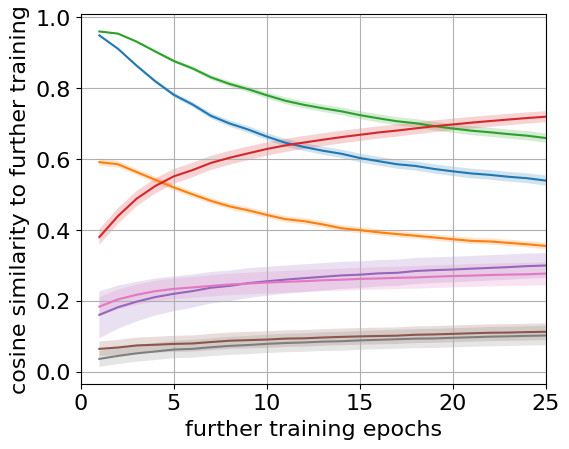

In [91]:
fig = plt.figure(figsize=(6., 4.8))
plt.plot(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], alpha=0.2)
if dataset == "fico":
    plt.xlim(-10, num_epochs)
elif dataset == "folktables":
    plt.xlim(0, num_epochs)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training epochs", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
#plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2)
#plt.savefig(os.path.join("figures", f"cos_sim_epochs_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")

#### Spearman correlation instead of cosine similarity

This section is intended to reproduce Figures 6(c)(d) in the paper

In [92]:
from scipy.stats import spearmanr

In [93]:
spearman_mean = pd.DataFrame(index=range(1, num_epochs + 1))
spearman_sem = pd.DataFrame(index=range(1, num_epochs + 1))

In [94]:
test_loss_further_train_diff_mean = test_loss_further_train_diff.mean(dim=3)
test_loss_further_train_diff_mean.shape

torch.Size([25, 10029, 100])

In [95]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        if dataset == "fico":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_dot[i, ind_loo].cpu()).statistic
        elif dataset == "folktables":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_dot[i, :].cpu()).statistic
spearman_mean["Grad-Dot"] = spearman.mean(axis=1)
spearman_sem["Grad-Dot"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [96]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        if dataset == "fico":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_cos[i, ind_loo].cpu()).statistic
        elif dataset == "folktables":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), grad_cos[i, :].cpu()).statistic
spearman_mean["Grad-Cos"] = spearman.mean(axis=1)
spearman_sem["Grad-Cos"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [97]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), -datainf[i, ind_loo, 0].cpu()).statistic
spearman_mean["DataInf"] = spearman.mean(axis=1)
spearman_sem["DataInf"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [98]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        if dataset == "fico":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), cg[i, ind_loo, 3].cpu()).statistic
        elif dataset == "folktables":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), cg[i, :, 3].cpu()).statistic
spearman_mean["CG"] = spearman.mean(axis=1)
spearman_sem["CG"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [99]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        if dataset == "fico":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa[i, ind_loo, 3].cpu()).statistic
        elif dataset == "folktables":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa[i, :, 3].cpu()).statistic
spearman_mean["LiSSA"] = spearman.mean(axis=1)
spearman_sem["LiSSA"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [100]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        if dataset == "fico":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa_no_gnh[i, ind_loo].cpu()).statistic
        elif dataset == "folktables":
            spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), lissa_no_gnh[i, :].cpu()).statistic
spearman_mean["LiSSA-H"] = spearman.mean(axis=1)
spearman_sem["LiSSA-H"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [101]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), ekfac[i, ind_loo].cpu()).statistic
spearman_mean["EK-FAC"] = spearman.mean(axis=1)
spearman_sem["EK-FAC"] = spearman.std(axis=1) / np.sqrt(num_test_eval)

In [102]:
spearman = np.zeros((num_epochs, num_test_eval))
for t in range(num_epochs):
    for i in range(num_test_eval):
        spearman[t, i] = spearmanr(test_loss_further_train_diff_mean[t,i,:].cpu(), trak[i, ind_loo].cpu()).statistic
spearman_mean["TRAK"] = spearman.mean(axis=1)
spearman_sem["TRAK"] = spearman.std(axis=1) / np.sqrt(num_test_eval)
spearman_mean

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.956735,0.810022,0.960266,-0.068288,0.072892,-0.005406,0.083881,-0.016403
2,0.874280,0.812624,0.972931,-0.013350,0.081326,-0.013010,0.091868,-0.012717
3,0.772238,0.776390,0.906372,0.060058,0.086415,-0.016503,0.091363,-0.014796
4,0.689616,0.739041,0.839032,0.128387,0.089483,-0.012032,0.097078,-0.012956
5,0.625287,0.703500,0.783170,0.178218,0.095340,-0.009596,0.098355,-0.009725
6,0.572697,0.668961,0.735011,0.221666,0.101433,-0.009240,0.097160,-0.007282
7,0.523381,0.636767,0.688579,0.259903,0.107179,-0.002515,0.097889,-0.009167
8,0.485956,0.610324,0.651233,0.292733,0.116802,-0.001281,0.102121,-0.008230
9,0.455032,0.581244,0.620348,0.317180,0.124768,-0.000229,0.103529,-0.004897
10,0.427070,0.559896,0.593215,0.340209,0.129968,0.005200,0.103172,-0.004564


In [103]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

Text(0, 0.5, 'Spearman corr. with further training')

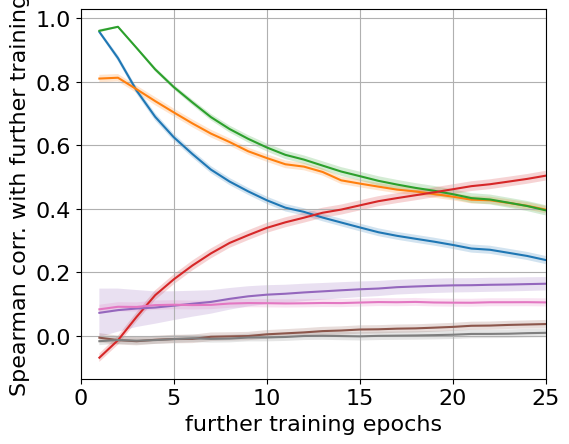

In [104]:
fig = plt.figure(figsize=(6., 4.8))
plt.plot(spearman_mean)
for method in spearman_mean.columns:
    plt.fill_between(spearman_mean.index, spearman_mean[method] - spearman_sem[method], spearman_mean[method] + spearman_sem[method], alpha=0.2)
if dataset == "fico":
    plt.xlim(-10, num_epochs)
elif dataset == "folktables":
    plt.xlim(0, num_epochs)
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("further training epochs", fontsize=fontsize)
plt.ylabel("Spearman corr. with further training", fontsize=fontsize)
#plt.legend(cos_sim_mean.columns, fontsize=fontsize, ncols=2)
# plt.savefig(os.path.join("figures", f"spearman_epochs_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")


### Average further training over different numbers of random seeds

This corresponds to Figures 3(a) and 7(c)(d) in the paper if `subtract_mean == True`, to Figures 9(c)(d) if `subtract_mean == False`, and to Figures 8(c)(d) if `optimizer_name == "adam"` and `subtract_mean == True`.

In [105]:
#kernel_sizes = [1, 5, 25]
kernel_sizes = [1, 2, 5, 10, 20, 50, 100]
num_epochs_avg = 1

cos_sim = {}
cos_sim_mean = pd.DataFrame(index=kernel_sizes)
cos_sim_sem = pd.DataFrame(index=kernel_sizes)

for k, kernel_size in enumerate(kernel_sizes):
    # Average further training results over moving windows of random seeds
    if kernel_size == 1:
        test_loss_further_train_diff_avg = test_loss_further_train_diff
    else:
        test_loss_further_train_diff_avg = F.avg_pool1d(test_loss_further_train_diff.view(-1, num_seeds), kernel_size=kernel_size).view(test_loss_further_train_diff.shape[:3] + (-1,))
    # Compute cosine similarity
    if dataset == "fico":
        cos_sim["Grad-Dot"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], grad_dot[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["Grad-Cos"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], grad_cos[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["DataInf"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], -datainf[:,ind_loo,0].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["CG"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], cg[:,ind_loo,3].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["LiSSA"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], lissa[:,ind_loo,3].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["LiSSA-H"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], lissa_no_gnh[:,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["EK-FAC"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], ekfac[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["TRAK"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], trak[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
    elif dataset == "folktables":
        cos_sim["Grad-Dot"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], grad_dot.unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["Grad-Cos"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], grad_cos.unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["DataInf"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], -datainf[:,ind_loo,0].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["CG"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], cg[:,:,3].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["LiSSA"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], lissa[:,:,3].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["LiSSA-H"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], lissa_no_gnh.unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["EK-FAC"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], ekfac[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
        cos_sim["TRAK"] = F.cosine_similarity(test_loss_further_train_diff_avg[:,:num_test_eval,:,:], trak[:num_test_eval,ind_loo].unsqueeze(0).unsqueeze(3), dim=2)
    for key in cos_sim.keys():
        # Aggregate over epochs
        # cos_sim[key] = cos_sim[key][:num_epochs_avg].mean(dim=0)
        # cos_sim_mean.loc[kernel_size, key] = cos_sim[key].mean().item()
        # cos_sim_sem.loc[kernel_size, key] = cos_sim[key].std().item() / np.sqrt(cos_sim[key].numel())
        cos_sim_mean.loc[kernel_size, key] = cos_sim[key].mean(dim=[1, 2]).max().item()
        step_max = cos_sim[key].mean(dim=[1, 2]).argmax()
        cos_sim_sem.loc[kernel_size, key] = cos_sim[key].std(dim=[1, 2])[step_max].item() / np.sqrt(cos_sim[key][0].numel())

cos_sim_mean
#print(cos_sim_sem)

,Grad-Dot,Grad-Cos,DataInf,CG,LiSSA,LiSSA-H,EK-FAC,TRAK
1,0.890479,0.564829,0.911882,0.708886,0.295826,0.111105,0.275118,0.100973
2,0.910206,0.573316,0.926149,0.712957,0.297320,0.111747,0.276159,0.101501
5,0.928572,0.582414,0.940140,0.716570,0.298592,0.112252,0.276841,0.101962
10,0.937571,0.586612,0.948840,0.718145,0.299256,0.112523,0.277051,0.102088
20,0.942106,0.588685,0.953252,0.719127,0.299586,0.112681,0.277138,0.102204
50,0.946459,0.590469,0.957564,0.719747,0.299815,0.112786,0.277193,0.102278
100,0.949302,0.591577,0.960472,0.719928,0.299881,0.112816,0.277203,0.102298


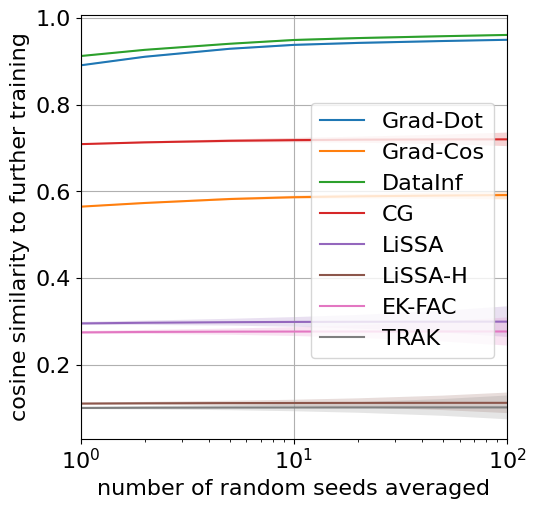

In [106]:
fig = plt.figure(figsize=(5.5, 5.5))
plt.semilogx(cos_sim_mean)
for method in cos_sim_mean.columns:
    plt.fill_between(cos_sim_mean.index, cos_sim_mean[method] - cos_sim_sem[method], cos_sim_mean[method] + cos_sim_sem[method], alpha=0.2)
plt.xlim(kernel_sizes[0], kernel_sizes[-1])
plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("number of random seeds averaged", fontsize=fontsize)
plt.ylabel("cosine similarity to further training", fontsize=fontsize)
if dataset == "folktables":
    if optimizer_name == "sgd" and subtract_mean:
        plt.legend(cos_sim_mean.columns, fontsize=fontsize, loc=(0.54, 0.19))
    else:
        plt.legend(cos_sim_mean.columns, fontsize=fontsize)
# plt.savefig(os.path.join("figures", f"cos_sim_seeds_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")


### Compare sorted attribution scores

This subsection was used to produce Figures 10(a)(b) in the paper

First average the further training attribution scores over random seeds

In [107]:
test_loss_further_train_diff_mean = test_loss_further_train_diff.mean(dim=3)

Then sort the attribution scores for each test instance before averaging the sorted scores over test instances

In [108]:
num_eval = 100

test_loss_further_train_diff_mean_sorted = test_loss_further_train_diff_mean[:,:num_eval,:].sort(dim=2).values
test_loss_further_train_diff_mean_sorted_mean = test_loss_further_train_diff_mean_sorted.mean(dim=1).cpu()
test_loss_further_train_diff_mean_sorted_sem = test_loss_further_train_diff_mean_sorted.std(dim=1).cpu() / np.sqrt(num_eval)

Compare against similarly sorted and averaged attribution scores from Grad-Dot and Grad-Cos

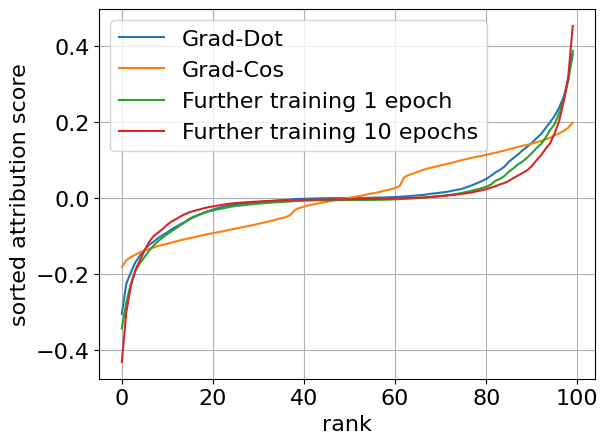

In [109]:
fontsize = 16
subtract_string = "" if subtract_mean else "_subfull"

if dataset == "fico":
    grad_dot_sorted_mean = grad_dot[:num_eval, ind_loo].sort(dim=1).values.mean(dim=0).cpu()
    grad_cos_sorted_mean = grad_cos[:num_eval, ind_loo].sort(dim=1).values.mean(dim=0).cpu()
elif dataset == "folktables":
    grad_dot_sorted_mean = grad_dot.sort(dim=1).values.mean(dim=0).cpu()
    grad_cos_sorted_mean = grad_cos.sort(dim=1).values.mean(dim=0).cpu()
plt.plot(grad_dot_sorted_mean / grad_dot_sorted_mean.norm())
plt.plot(grad_cos_sorted_mean / grad_cos_sorted_mean.norm())
#epoch, step = 0, 0

if dataset == "fico":
    epochs = [0]
elif dataset == "folktables":
    epochs = [0, 9]
for epoch in epochs:
#plt.plot(test_loss_further_train_diff_mean_sorted_mean[epoch,step])
    plt.plot(test_loss_further_train_diff_mean_sorted_mean[epoch] / test_loss_further_train_diff_mean_sorted_mean[epoch].norm())
#plt.fill_between(range(num_leave_out), 
#                 test_loss_further_train_diff_mean_sorted_mean[epoch,step] - test_loss_further_train_diff_mean_sorted_sem[epoch,step], 
#                 test_loss_further_train_diff_mean_sorted_mean[epoch,step] + test_loss_further_train_diff_mean_sorted_sem[epoch,step],
#                 alpha=0.15)

plt.grid()
plt.tick_params(labelsize=fontsize)
plt.xlabel("rank", fontsize=fontsize)
plt.ylabel("sorted attribution score", fontsize=fontsize)
if dataset == "fico":
    plt.legend(["Grad-Dot", "Grad-Cos", f"Further training {epochs[0]+1} epoch"], fontsize=fontsize)
elif dataset == "folktables":
    plt.legend(["Grad-Dot", "Grad-Cos", f"Further training {epochs[0]+1} epoch", f"Further training {epochs[1]+1} epochs"], fontsize=fontsize)
# plt.savefig(os.path.join("figures", f"attrib_scores_{optimizer_name}{subtract_string}_{dataset}.pdf"), bbox_inches="tight")


[[back to top]](#Tabular-classification-notebook)